### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'mean_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory already exsist!


In [4]:
for i in ['RandomForest_WO']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory already exsist!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [7]:
def impute_mean(group):
    return group.fillna(group.mean())

nan_cols = train.isna().sum()[train.isna().sum()>0].index.tolist()

for i in nan_cols:
    train[i] = train[i].transform(impute_mean)
    
nan_cols = test.isna().sum()[test.isna().sum()>0].index.tolist()

for i in nan_cols:
    test[i] = test[i].fillna(test[i].mean())

In [8]:
# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
#               'mini_sea_total', 'barthel_total', 'pfeffer_total',  'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition', 'functionality',
#               'marital_status', 'n_children', 'household_members', 'household_income', 'Job_status',
#               'income_s_NaN', 'income_s_1', 'income_s_2', 'income_s_3', 'income_s_4', 'income_s_5',
#               'income_s_6', 'income_s_7','income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata']

final_cols = ['site', 'id', 'diagnosis', 
              'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
              'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw','ace_vs', 'ace_lw', 'barthel_total',
              'pfeffer_total','cognition', 'functionality', 'strata']

final_cols2 = ['site', 'id','diagnosis', 'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver', 
                'cognition', 'functionality', 'strata']


train = train[final_cols2]
test = test[final_cols2]
    
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [9]:
test

,site,id,diagnosis,ifs_total_score,mini_sea_total,npi_total,npi_total_caregiver,cognition,functionality,strata
0,Behrens,PBE00067,AD,19.738462,22.173968,8.036364,11.535714,0.775347,0.338672,AD / Behrens
1,Behrens,PBE00052,AD,19.738462,22.173968,8.036364,11.535714,0.000000,0.338672,AD / Behrens
2,Behrens,PBE00090,AD,19.738462,22.173968,8.036364,11.535714,0.670833,0.338672,AD / Behrens
3,Behrens,PBE00049,AD,19.738462,22.173968,8.036364,11.535714,0.381771,0.338672,AD / Behrens
4,Behrens,PBE00025,AD,19.738462,22.173968,8.036364,11.535714,0.670833,0.338672,AD / Behrens
...,...,...,...,...,...,...,...,...,...,...
156,Slachevsky,PSL00160,FTD,8.000000,18.600000,12.000000,5.000000,0.480556,0.338672,FTD / Slachevsky
157,Slachevsky,PSL00089,FTD,13.500000,21.107000,21.000000,19.000000,0.831250,0.393939,FTD / Slachevsky
158,Slachevsky,PSL00163,FTD,21.500000,23.200000,23.000000,11.535714,0.812500,0.338672,FTD / Slachevsky
159,Slachevsky,PSL00090,FTD,21.500000,22.982000,12.000000,13.000000,0.938194,0.212121,FTD / Slachevsky


In [10]:
train.columns

Index(['site', 'id', 'diagnosis', 'ifs_total_score', 'mini_sea_total',
       'npi_total', 'npi_total_caregiver', 'cognition', 'functionality',
       'strata'],
      dtype='object')

In [11]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

train.shape, test.shape

((1450, 7), (161, 7))

In [12]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh

In [13]:
### Load Hyperparams

### Load Hyperparams

hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-11-25/mean_hparams/"

rf_hp = pd.read_csv(hparams_path + "RF_hparams_fcols2.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp= rf_hp[rf_hp['mean_test_score'] < rf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

In [14]:
rf_row = 1
rf_hp.iloc[rf_row,:]

param_criterion                                                         gini
param_max_depth                                                            6
param_max_features                                                         6
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                       500
params                     OrderedDict([('criterion', 'gini'), ('max_dept...
mean_test_score                                                     0.807472
mean_train_score                                                    0.903186
Name: 1, dtype: object

In [15]:
## Models Hparams
# RF
rf_params= {"n_estimators": rf_hp.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

In [16]:
n_iter =5000

### Base model: Logistic Regression

In [17]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating: 100%|██████████████████| 5000/5000 [02:55<00:00, 28.50it/s]


singular_matrix_errors (droped from results): 0
Eleapsed time:2.924355693658193 minutes
empirical p-value: 0.001


In [18]:
lr_res.mean()

Accuracy         0.778304
ROC_AUC          0.709393
Precision        0.660493
Recall           0.131161
Sensitivity      0.131161
Specificity      0.978093
F1               0.215482
Efron_pR2        0.129298
mcfadden_pR2     0.100783
mcfadden_apR2    0.047832
dtype: float64

In [19]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.011514,0.012585,0.013126,0.009357,0.009357,0.004057,0.011397,0.0093,0.008344,0.005915


In [20]:
lr_res_r.head()

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,cognition,2.029058,0.202471,10.942837,1.233371,0.000000,0.000000e+00
1,functionality,0.104046,0.206758,0.456421,0.917573,0.964883,4.390910e-02
2,ifs_total_score,-3.899288,0.207604,-15.114611,1.343705,0.000000,0.000000e+00
3,mini_sea_total,-0.126035,0.224341,-0.280731,0.553117,0.999757,3.799142e-06
4,npi_total,0.090796,0.200653,0.244089,0.576241,0.999994,2.220446e-16


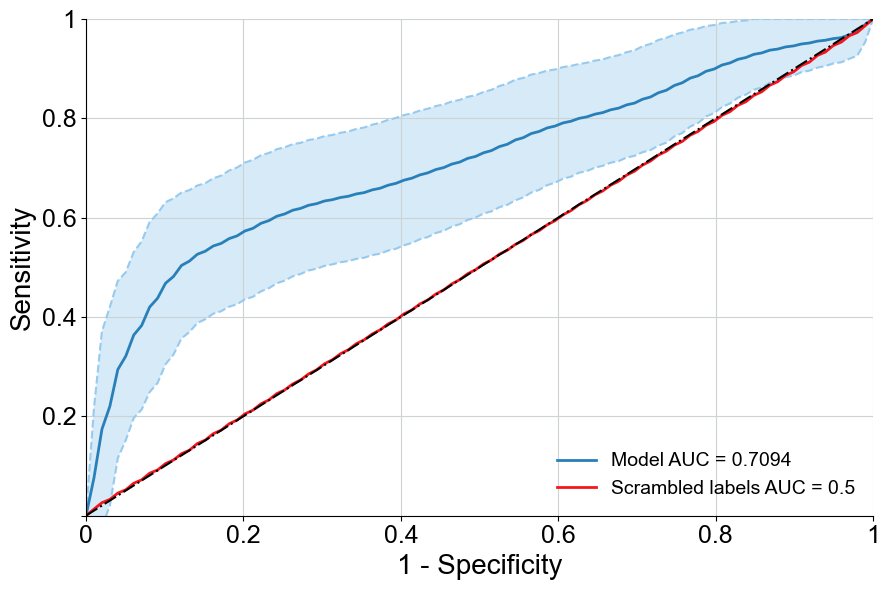

In [21]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [22]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [23]:
rf_fimp.sort_values('mean', ascending=False)#.to_csv(path_res+ "/RandomForest_WO/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

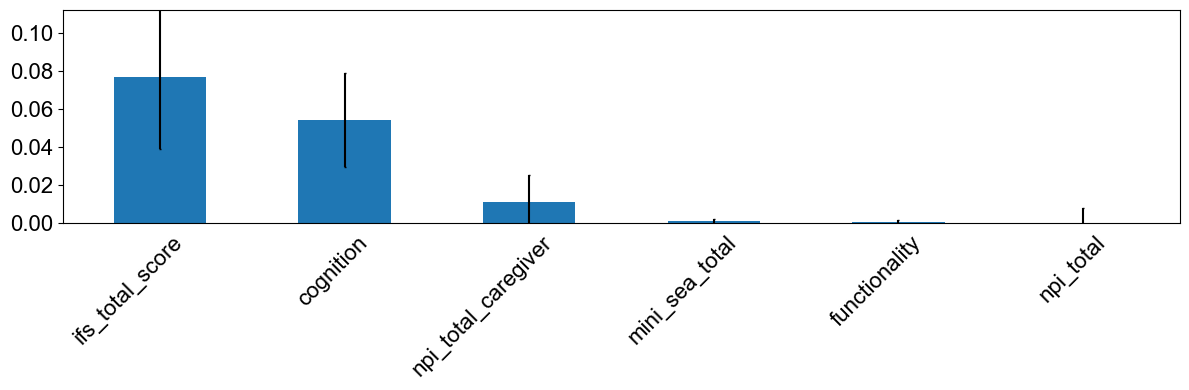

In [24]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

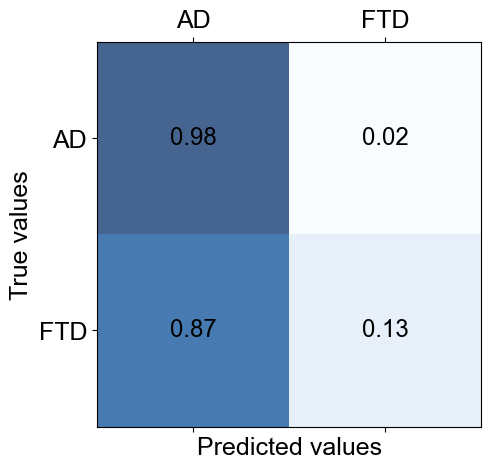

In [25]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['AD', 'FTD'],fname=None)

#### unseen data

In [26]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [27]:
X_train.columns, X_test.columns

(Index(['ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
        'cognition', 'functionality'],
       dtype='object'),
 Index(['ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
        'cognition', 'functionality'],
       dtype='object'))

In [28]:
X_test

,ifs_total_score,mini_sea_total,npi_total,npi_total_caregiver,cognition,functionality
0,24.000000,22.000000,12.000000,11.535714,0.719444,0.181818
1,15.000000,22.071000,9.000000,12.000000,0.724306,0.515152
2,27.500000,28.710000,8.036364,11.535714,0.941667,0.000000
3,19.738462,22.173968,8.036364,11.535714,0.627431,0.500000
4,17.500000,21.857000,8.036364,11.535714,0.768750,0.030303
...,...,...,...,...,...,...
102,19.738462,22.173968,8.036364,11.535714,0.298958,0.338672
103,19.738462,22.173968,8.036364,11.535714,0.475347,0.338672
104,19.738462,22.173968,8.036364,11.535714,0.710417,0.338672
105,19.000000,24.000000,16.000000,11.535714,0.720833,0.181818


In [29]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_test.iloc[:,:] = scaler.transform(X_test.iloc[:,:])

In [30]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)

In [31]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [32]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.5278
Accuracy: 0.7664
Recall: 0.08
F1: 0.1379
Precision:0.5


In [33]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.5278
Bootstrping test ROC score: 	0.7094


### RF Model

##### Bootstrap

In [34]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=6,
                       min_samples_leaf=0.01, min_samples_split=0.01,
                       n_estimators=500, n_jobs=-1)


Iterating: 100%|████████████████| 5000/5000 [1:24:00<00:00,  1.01s/it]

singular_matrix_errors (droped from results): 0
Eleapsed time:84.01260601679483 minutes
empirical p-value: 0.0


In [35]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2024-01-09/mean_res'

In [36]:
Model_res.to_csv(path_res+ "/RandomForest_WO/Model_res.csv", index=False)
Model_res.mean()

Accuracy       0.783704
ROC_AUC        0.821273
Precision      0.536761
Recall         0.652274
Sensitivity    0.652274
Specificity    0.824279
F1             0.586985
Efron_pR2      0.171445
dtype: float64

In [37]:
print("%.4f" % Model_res['ROC_AUC'].mean())


0.8213


In [38]:
CI_df.to_csv(path_res+ "/RandomForest_WO/CI_df.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.011412,0.01062,0.013822,0.013201,0.013201,0.010549,0.013648,0.010447


In [39]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest_WO/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
2,ifs_total_score,0.381046,0.021495
0,cognition,0.276034,0.023804
4,npi_total,0.137505,0.017889
1,functionality,0.114443,0.018430
5,npi_total_caregiver,0.048635,0.012321
3,mini_sea_total,0.042337,0.008029


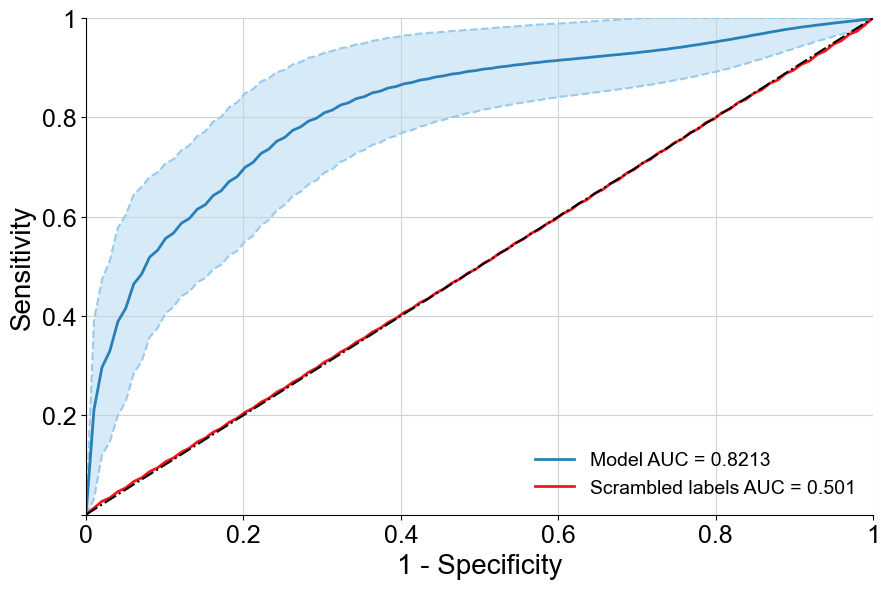

In [40]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest_WO/ROC_AUC_curve.png")
# Fig save?


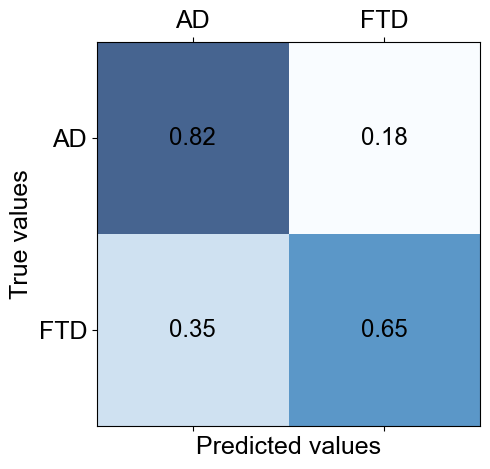

In [41]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest_WO/CM.png")

##### Permutation Feature importance

In [42]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [43]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest_WO/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

In [44]:
top_10p.head()

,predictor,mean,std
0,ifs_total_score,0.226426,0.035801
4,cognition,0.083050,0.014945
2,npi_total,0.049629,0.012815
5,functionality,0.039287,0.013514
3,npi_total_caregiver,0.009631,0.005013


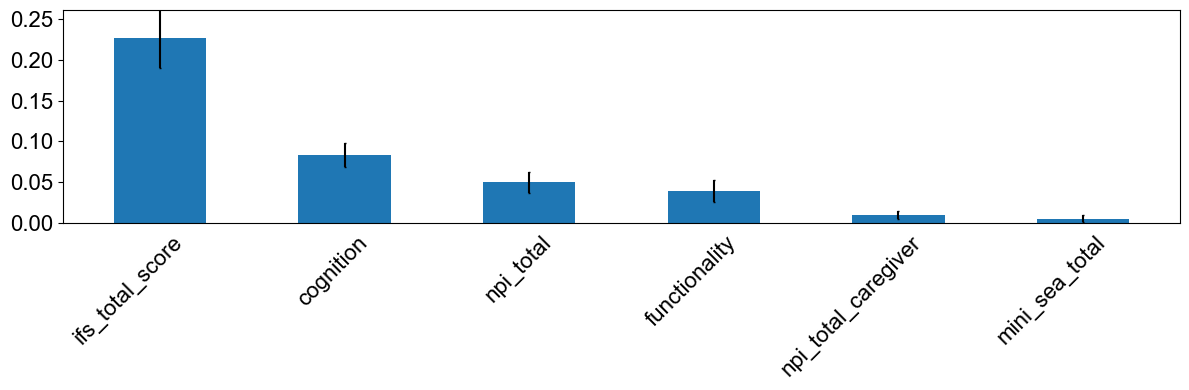

In [45]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

In [46]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
2,ifs_total_score,0.381046,0.021495
0,cognition,0.276034,0.023804
4,npi_total,0.137505,0.017889
1,functionality,0.114443,0.018430
5,npi_total_caregiver,0.048635,0.012321


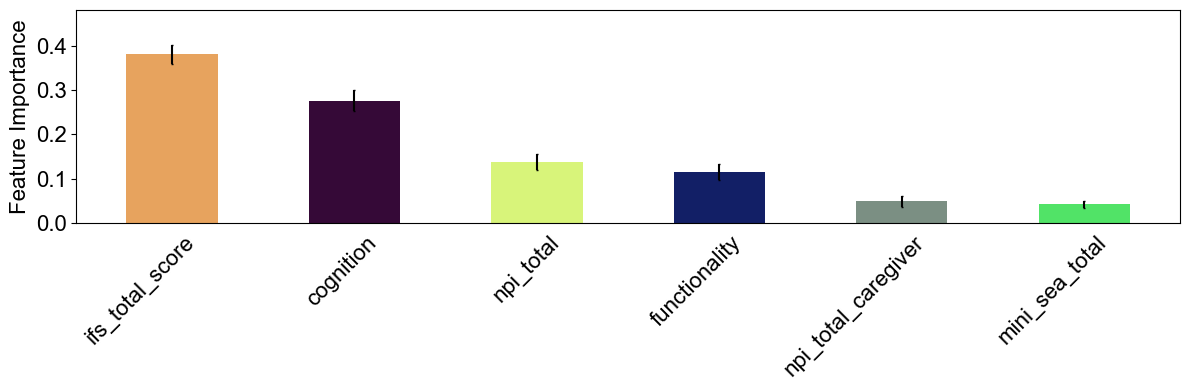

In [47]:
top_10 = Model_res_r.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [48]:
# X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
# X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [49]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = confusion_matrix(y_test, y_pred, normalize='true')

In [50]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/RandomForest_WO/unseen.csv")

In [51]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.7346
Accuracy: 0.785
Recall: 0.64
F1: 0.5818
Precision:0.5333


In [52]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.7346
Bootstrping test ROC score: 	0.8213


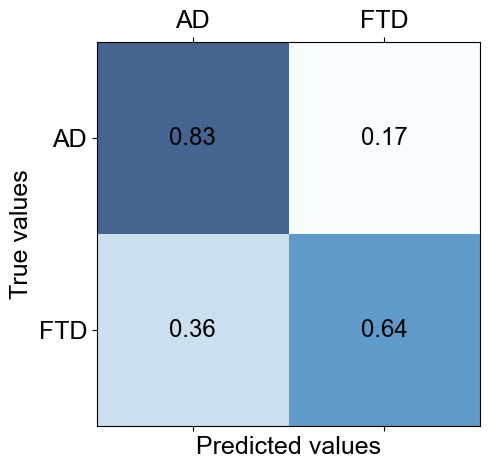

In [53]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'], fname=path_res+ "/RandomForest_WO/ROC_AUC_curve_unseen.png")

#### Shapley

In [54]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_test, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


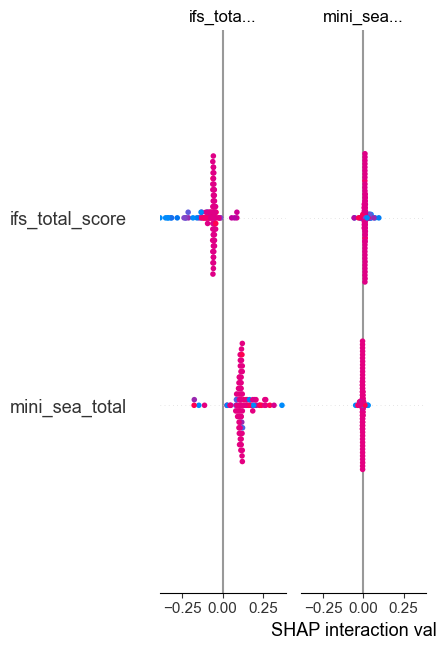

In [55]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

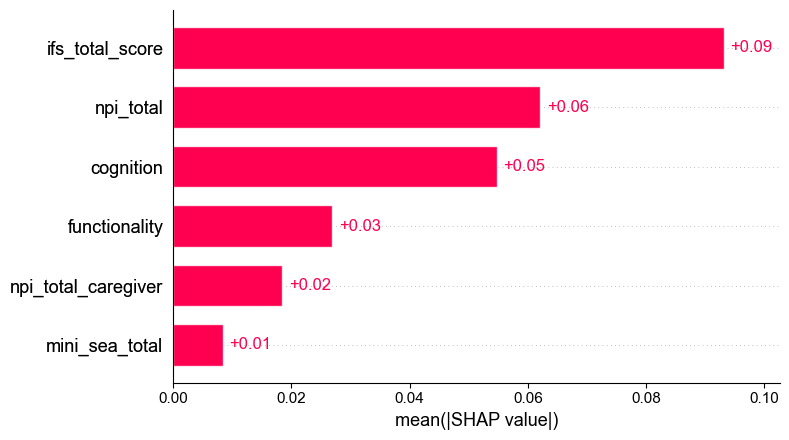

In [56]:
shap.plots.bar(shap_values[:,:,1])

In [57]:
# shap.plots.beeswarm(shap_values[:,:,1])

In [58]:
# # compute SHAP values
# explainer2 = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist())
# shap_values2 = explainer(X_test, check_additivity=False)

In [59]:
# shap.summary_plot(shap_values2[:,:,1])

In [60]:
# shap.plots.bar(shap_values2[:,:,1])

In [61]:

# # Convertir shap_values en un DataFrame
# shap_df = pd.DataFrame(shap_values, columns=X_train.columns.tolist())

# # Guardar el DataFrame en un archivo CSV
# shap_df.to_csv('shap_values.csv', index=False)


In [62]:
# shap_values2[:,:,1]